We're going to investigate the RHL's reinterpretation of the ZOGY (2016) algorithm which is described in RHL's slides as a post-convolution (in Fourier space) of the diffim:

$$
D(k) = [I_1(k) - \kappa(k) I_2(k)] \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}},
$$

where $I_1$ and $I_2$ are the two images, $\sigma_1$ and $\sigma_2$ are their respective variances, and $\kappa$ is the PSF-matching kernel. Note that this is for the case of "preconvolution" of $I_1$ with its own PSF, so that if $I_1$ and $I_2$ have the same seeing, then $\kappa$ = $\phi_1$ (where $\phi_1$ is the PSF of $I_1$). The resulting PSF of the diffim $D$ is:

$$
\phi_D(k) = \phi_1(k) \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

Thus, we may interpret the image difference as being **post-convolved** with a kernel of the form

$$
\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

If we wish to incorporate this post-convolution into our current framework which works in real-space, it is simply a matter of inverse Fourier-transforming the kernel into real-space, and then convolving it with the diffim.

But what does this post-convolution kernel actually look like?

In [1]:
import sympy as sym
import sympy.stats as symstat
from sympy.interactive import printing
sym.init_printing()

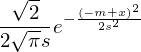

In [2]:
x,F,m,s,k,n = sym.symbols("x F m s k n")
G = 1/(s*sym.sqrt(2*sym.pi)) * sym.exp(-(x-m)**2/(2*s**2))
G

In [3]:
G.evalf(subs={x: 0, m: 0, s: 1})

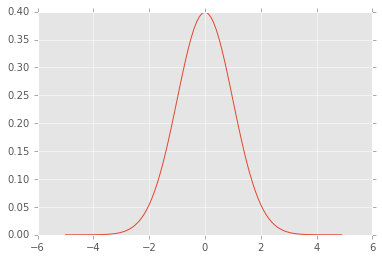

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

qq = [G.evalf(subs={x: xx, m: 0, s: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)

In [5]:
H = sym.fourier_transform(G, x, k)
H

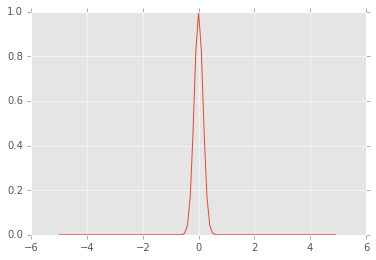

In [6]:
qq = [H.evalf(subs={k: xx, m: 0, s: 1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)

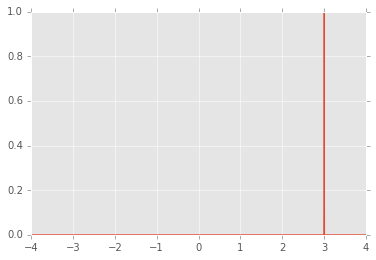

In [7]:
D = sym.KroneckerDelta(x, 3.0)
xrange = np.arange(-4,4,0.01)
xrange[np.abs(xrange-3.0) <= 1e-5] = 3.0
qq = [D.evalf(subs={x: xx}) for xx in xrange]
plt.plot(xrange, qq)

Looks like sympy doesn't handle Fourier transforms of Delta functions correctly. See:
http://stackoverflow.com/questions/33208737/continuous-fourier-transform-with-python-sympy-analytical-solution

Numerical try, see:

http://www.leadnovo.com/4444999026.htm

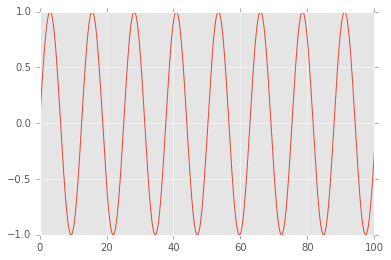

In [8]:
from scipy.fftpack import fft, fftfreq
t = np.linspace(0., 100., 2000)
signal = np.sin(t / 2.)
plt.plot(t, signal)

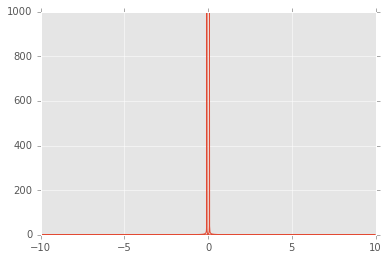

In [9]:
npts = len(t)
FFT = fft(signal)
freqs = fftfreq(npts, t[1]-t[0])
plt.plot(freqs, abs(FFT))

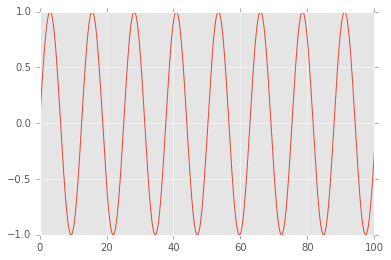

In [10]:
from scipy.fftpack import ifft
signal2 = ifft(FFT)
plt.plot(t, signal2.real)

### Let's take a look at the Lupton(ZOGY) "post-convolution" kernel...

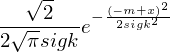

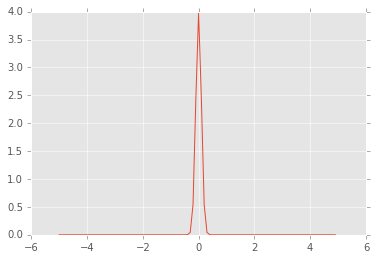

In [11]:
# Define kappa(x) (the spatial matching kernel) as a simple narrow Gaussian:
sigk = sym.symbols("sigk")

kappa = 1/(sigk*sym.sqrt(2*sym.pi))*sym.exp(-(x-m)**2/(2*sigk**2))
qq = [kappa.evalf(subs={x: xx, m: 0, sigk: 0.1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
kappa

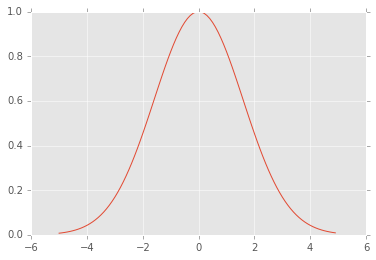

In [12]:
# Now define kappa_ft(k) (the FT of the matching kernel kappa):
kappa_ft = sym.fourier_transform(kappa, x, k)
qq = [kappa_ft.evalf(subs={k: xx, m: 0, sigk: 0.1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
kappa_ft

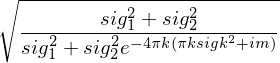

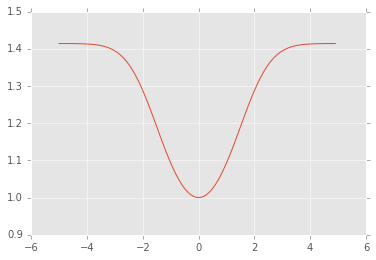

In [13]:
sig1, sig2 = sym.symbols("sig1 sig2")
# post_conv_kernel = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
post_conv_kernel_ft = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft**2))
qq = [post_conv_kernel_ft.evalf(subs={k:xx, m:0, sigk:0.1, sig1:1, sig2:1}) for xx in np.arange(-5,5,0.1)]
plt.plot(np.arange(-5,5,0.1), qq)
post_conv_kernel_ft

In [14]:
# This takes a long time so let's look at it numerically instead...
if False:
    post_conv_kernel = sym.inverse_fourier_transform(post_conv_kernel_ft, k, x, noconds=False)
    post_conv_kernel

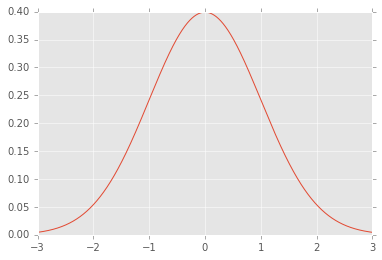

In [15]:
def kappa(x, m=0., sigk=1.0):
    out = 1/(sigk*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*sigk**2.))
    return out / out.sum() / (x[1] - x[0])

x = np.arange(-10,10,0.001)
plt.plot(x[abs(x)<3], kappa(x)[abs(x)<3])

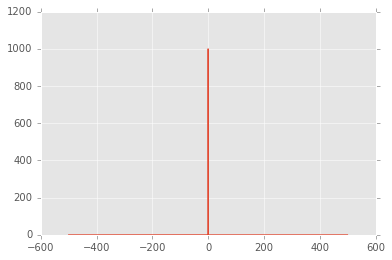

In [16]:
def kappa_ft(x, m=0., sigk=1.0):
    kp = kappa(x, m, sigk)
    npts = len(x)
    FFT = fft(kp)
    freqs = fftfreq(npts, x[1]-x[0])  # assumes uniformly sampled x!
    return FFT, freqs

FFT, freqs = kappa_ft(x)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(abs(FFT)))

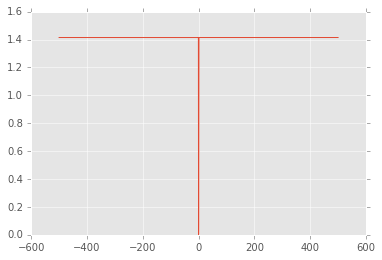

In [17]:
# post_conv_kernel = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
def post_conv_kernel_ft(x, sig1=1., sig2=1., m=0., sigk=1.):
    kft, freqs = kappa_ft(x, m, sigk)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2)), freqs

kft, freqs = post_conv_kernel_ft(x)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(kft.real))

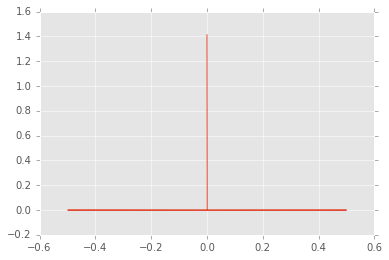

In [18]:
def post_conv_kernel(x, sig1=1., sig2=1., m=0., sigk=1.0):
    kft, freqs = post_conv_kernel_ft(x, sig1, sig2, m, sigk)
    out = ifft(kft)
    return out

pck = post_conv_kernel(x)
xx = np.fft.ifftshift(x)
plt.plot(xx[np.abs(xx) <= 0.5], pck.real[np.abs(xx) <= 0.5])

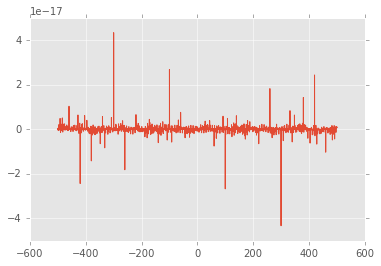

In [19]:
# Ensure there is no trend in the imag. component:
plt.plot(np.fft.ifftshift(freqs), pck.imag)

Let's look at it for given limits.

1. case 1 (Cell #18): $\sigma_1 = \sigma_2$ and $\kappa$ is a gaussian with $\sigma=1$ (note that $\kappa$ in this case is the matching kernel between the "pre-convolved" $I_1$ and the "template" $I_2$). In this case, the "post-convolution" kernel is a $\delta$-function with amplitude equal to $\sqrt(2)$. 
2. case 2 (Cell #20): $\sigma_2 = 0$ (i.e. a template with no noise). As expected, the "post-convolution" kernel is a $\delta$-function with amplitude equal to $1$. (See Cell #25).
3. case 3 (Cell #21): deconvolution where $\kappa$ is narrower than one. This increases the width of $\kappa$ in $k$ space and thus decreases the amplitude of the $\delta$-function in real-space (and adds ringing/width).
4. case 4 (Cell #22): case where template $I_2$ is noisier than the image, let's just set $\sigma_1 = 0.1$. The result is still a $\delta$-function but with amplitude $1/\sigma_1$ - so we re-scale the variance by this amount.

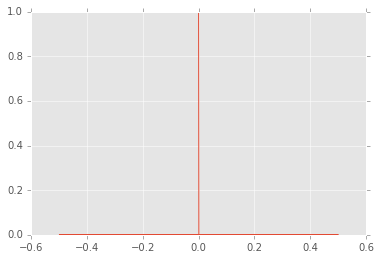

In [20]:
pck = post_conv_kernel(x, sig2=0.)
xx = np.fft.ifftshift(x)
plt.plot(xx[np.abs(xx) <= 0.5], pck.real[np.abs(xx) <= 0.5])

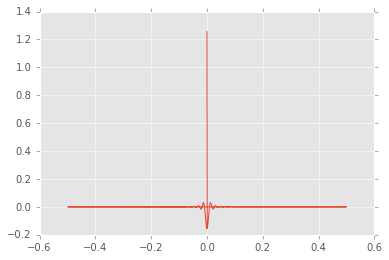

In [21]:
pck = post_conv_kernel(x, sigk=0.01)
xx = np.fft.ifftshift(x)
plt.plot(xx[np.abs(xx) <= 0.5], pck.real[np.abs(xx) <= 0.5])

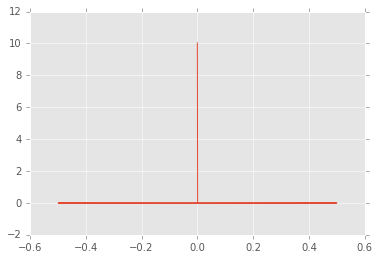

In [22]:
pck = post_conv_kernel(x, sig1=0.1)
xx = np.fft.ifftshift(x)
plt.plot(xx[np.abs(xx) <= 0.5], pck.real[np.abs(xx) <= 0.5])

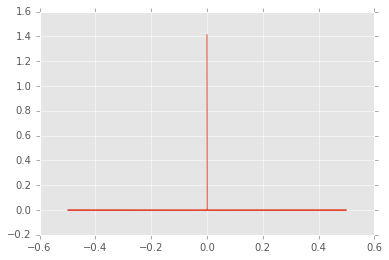

In [23]:
pck = post_conv_kernel(x, m=3.) ## look at offset
xx = np.fft.ifftshift(x)
plt.plot(xx[np.abs(xx) <= 0.5], pck.real[np.abs(xx) <= 0.5])